Alanine dipeptide normalizing Flow
------
Normalizing Flow using RealNVP for sampling Alanine dipeptide structures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mdtraj as md
import matplotlib as mpl

In [2]:
import torch

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [4]:
from bgtorch.nn.flow.base import Flow
from bgtorch.nn import DenseNet
from bgtorch.nn.flow import (
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow,
    MergeFlow,
    InverseFlow, 
    SwapFlow
)
from bgtorch.nn.flow.transformer import AffineTransformer
from bgtorch.distribution.energy import Energy
from bgtorch.distribution.sampling import Sampler
from bgtorch.distribution import NormalDistribution
from bgtorch import BoltzmannGenerator
from bgtorch.nn.training import KLTrainer

In [5]:
rcParams.update({'font.size': 16})

In [6]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

Ala2
---

In [7]:
def plot_2ala_ramachandran(traj, ax=None, weights=None):
    if ax==None:
        ax = plt.gca()
    

    if isinstance(weights, np.ndarray):
        ax.hist2d(md.compute_phi(traj)[1].reshape(-1), 
                  md.compute_psi(traj)[1].reshape(-1), 
                  bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
                  norm=mpl.colors.LogNorm(),
                  weights=weights)
    else:
        ax.hist2d(md.compute_phi(traj)[1].reshape(-1), 
                  md.compute_psi(traj)[1].reshape(-1), 
                  bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
                  norm=mpl.colors.LogNorm())
        
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')    

In [8]:
from openmmtools.testsystems import AlanineDipeptideVacuum

In [9]:
ala2 = AlanineDipeptideVacuum(constraints=None)

In [10]:
temperature = 1000
n_atoms = ala2.mdtraj_topology.n_atoms

In [11]:
from simtk import openmm, unit
INTEGRATOR_ARGS = (temperature*unit.kelvin, 
                   1.0/unit.picoseconds, 
                   1.0*unit.femtoseconds)

In [14]:
from bgtorch.distribution.energy.openmm import OpenMMEnergy, OpenMMEnergyBridge
ala2_omm_energy_bridge = OpenMMEnergyBridge(ala2.system, unit.nanometers, 
                                            openmm_integrator=openmm.LangevinIntegrator, 
                                            openmm_integrator_args=INTEGRATOR_ARGS)

ala2_omm_energy = OpenMMEnergy(3 * n_atoms, ala2_omm_energy_bridge)

In [15]:
from bgtorch.utils.train import linlogcut

class AugmentedEnergy(Energy):
    def __init__(self, base_model, high_energy=None, max_energy=None):
        super().__init__(2 * base_model.dim)
        self.base_model = base_model
        self.high_energy = high_energy
        self.max_energy = max_energy
    
    def _energy(self, x, temperature=None):
        U = self.base_model.energy(x[:, :self.base_model.dim])
        if self.high_energy is not None or self.max_energy is not None:
            U_mod = linlogcut(U, high_val=self.high_energy, max_val=self.max_energy, inplace=True)
            #U_mod = _linlogcut(U, self.high_energy, self.max_energy)
        else:
            U_mod = U
        
        K = 0.5 * (x[:, self.base_model.dim:] ** 2).sum(axis=1, keepdim=True)            
        return U_mod + K

Load training data
---

In [16]:
ala2_pdb = md.load('./data/alanine-dipeptide.pdb').topology
training_data_traj = md.load('./data/ala2_1000K_train.xtc', top=ala2_pdb)

In [18]:
phi = md.compute_phi(training_data_traj)[1].reshape(-1)
psi = md.compute_psi(training_data_traj)[1].reshape(-1)

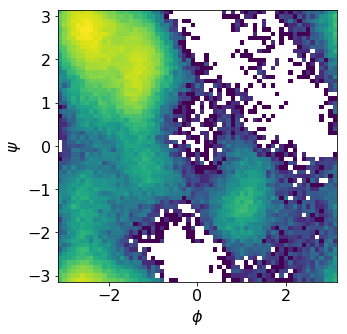

In [23]:
plt.figure(figsize=(5, 5))
plot_2ala_ramachandran(training_data_traj)

In [28]:
training_data = training_data_traj.xyz.reshape((training_data_traj.xyz.shape[0], 
                                                3*training_data_traj.xyz.shape[1]))
training_data = torch.tensor(training_data)
training_data.requires_grad = True

Internal Coordinates
---

In [26]:
for atom in ala2_pdb.atoms:
    print(atom)

ACE1-H1
ACE1-CH3
ACE1-H2
ACE1-H3
ACE1-C
ACE1-O
ALA2-N
ALA2-H
ALA2-CA
ALA2-HA
ALA2-CB
ALA2-HB1
ALA2-HB2
ALA2-HB3
ALA2-C
ALA2-O
NME3-N
NME3-H
NME3-C
NME3-H1
NME3-H2
NME3-H3


In [27]:
rigid_block = np.array([6, 8, 9, 10, 14])
Z = np.array([[0, 1, 4, 6],
              [1, 4, 6, 8],
              [2, 1, 4, 0],
              [3, 1, 4, 0],
              [4, 6, 8, 14],
              [5, 4, 6, 8],
              [7, 6, 8, 4],
              [11, 10, 8, 6],
              [12, 10, 8, 11],
              [13, 10, 8, 11],
              [15, 14, 8, 16],
              [16, 14, 8, 6],
              [17, 16, 14, 15],
              [18, 16, 14, 8],
              [19, 18, 16, 14],
              [20, 18, 16, 19],
              [21, 18, 16, 19]])

In [36]:
from bgtorch.nn.flow.crd_transform.ic import MixedCoordinateTransform
mct = MixedCoordinateTransform(rigid_block, Z, X0=training_data, remove_dof=6)

Boltzmann Generator
-------

In [29]:
def RNVP(shift_nhidden, scale_nhidden,
         shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.Tanh(), 
         shift_weight_scale=1.0, scale_weight_scale=1.0, 
         shift_bias_scale=0.0, scale_bias_scale=0.0, init_downscale=1.0):
    
    shift_transformation = None
    if shift_nhidden is not None:
        shift_transformation=DenseNet(shift_nhidden, activation=shift_activation, 
                                      weight_scale=shift_weight_scale, bias_scale=shift_bias_scale)            
    scale_transformation = None
    if scale_nhidden is not None:
        scale_transformation=DenseNet(scale_nhidden, activation=scale_activation, 
                                      weight_scale=scale_weight_scale, bias_scale=scale_bias_scale)
    transformer = AffineTransformer(shift_transformation=shift_transformation,
                                    scale_transformation=scale_transformation,
                                    init_downscale=init_downscale) 
    return CouplingFlow(transformer)

In [30]:
class WrapLeft(Flow):
    def __init__(self, leftflow):
        super().__init__()
        self.leftflow = leftflow

    def _forward(self, x1, x2, **kwargs):
        y1, dlogp = self.leftflow(x1)
        return y1, x2, dlogp
    
    def _inverse(self, x1, x2, **kwargs):
        y1, dlogp = self.leftflow(x1, inverse=True)
        return y1, x2, dlogp


In [31]:
def build_XV_RNVP(hamiltonian_prior, hamiltonian_target, crd_transform, 
                  n_transform, shift_nhidden, scale_nhidden):
    # here we aggregate all layers of the flow
    layers = []

    dim_x = hamiltonian_target.dim // 2
    dim_v = dim_x
    dim_ic = dim_x - 6
    
    # split
    layers.append(SplitFlow(dim_ic))        
        
    # RealNVP block
    for i in range(n_transform):
        # ic(x) -> v
        layers.append(RNVP([dim_ic] + shift_nhidden + [dim_v], [dim_ic] + scale_nhidden + [dim_v], 
                      shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.ReLU()))
        layers.append(SwapFlow())
        # v -> ic(x)
        layers.append(RNVP([dim_v] + shift_nhidden + [dim_ic], [dim_v] + scale_nhidden + [dim_ic], 
                      shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.ReLU()))
        layers.append(SwapFlow())

    # add crd transform
    layers.append(WrapLeft(crd_transform))
            
    # merge
    layers.append(MergeFlow(dim_x))

    # now define the flow as a sequence of all operations stored in layers
    flexflow = SequentialFlow(layers)
    
    bg = BoltzmannGenerator(hamiltonian_prior, flexflow, hamiltonian_target)
    
    return bg    

In [32]:
class CenteredNormalPrior(Energy, Sampler):
    """ 2 particles in 1d """
    def __init__(self, nparticles, ndim=3, center_x=True, center_v=True):
        super().__init__(2*nparticles*ndim)
        self.nparticles = nparticles
        self.ndim = ndim
        self.center_x = center_x
        self.center_v = center_v
    
    def _energy(self, x):
        return 0.5 * (x ** 2).sum(dim=1, keepdim=True)

    def sample(self, n_samples, temperature=1.):
        # positions
        x = torch.Tensor(n_samples, self.nparticles, self.ndim).normal_()
        if self.center_x:
            xc = (x - x.mean(dim=1, keepdim=True)).reshape(n_samples, self.nparticles * self.ndim)
        else:
            xc = x.reshape(n_samples, self.nparticles * self.ndim)
        # velocities
        v = torch.Tensor(n_samples, self.nparticles, self.ndim).normal_()
        if self.center_v:
            vc = (v - v.mean(dim=1, keepdim=True)).reshape(n_samples, self.nparticles * self.ndim)
        else:
            vc = v.reshape(n_samples, self.nparticles * self.ndim)
        # merge
        xvc = torch.cat([xc, vc], dim=1)
        return xvc

In [33]:
dim_x = 66
dim_ic = 60

In [34]:
hamiltonian_prior = NormalDistribution(dim_ic + dim_x)
hamiltonian_target = AugmentedEnergy(ala2_omm_energy, high_energy=500, max_energy=10000)

In [37]:
bg = build_XV_RNVP(hamiltonian_prior, hamiltonian_target, mct, 
                   5, [128, 128, 128], [128, 128, 128])

In [38]:
trainer = KLTrainer(bg, train_likelihood=True, train_energy=True,
                    optim = torch.optim.Adam(bg.parameters(), lr=1e-3))

In [39]:
batchsize = 256

In [40]:
# add velocities
xv_aligned = torch.cat([training_data, torch.zeros_like(training_data).normal_()], dim=1)

In [41]:
trainer.train(1000, data=xv_aligned, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: -54.2732	KLL: 228.3111	
21	NLL: -56.7074	KLL: 218.1371	
41	NLL: -57.2294	KLL: 231.5903	
61	NLL: -56.5638	KLL: 240.9319	
81	NLL: -57.5110	KLL: 221.1468	
101	NLL: -57.8198	KLL: 231.6376	
121	NLL: -57.8288	KLL: 227.4171	
141	NLL: -56.7296	KLL: 216.9637	
161	NLL: -57.4042	KLL: 221.5681	
181	NLL: -59.1010	KLL: 209.0111	
201	NLL: -57.9445	KLL: 218.1577	
221	NLL: -57.3758	KLL: 206.7437	
241	NLL: -58.3927	KLL: 204.3618	
261	NLL: -59.5990	KLL: 208.0047	
281	NLL: -59.6057	KLL: 219.5818	
301	NLL: -58.8725	KLL: 207.3417	
321	NLL: -58.4459	KLL: 216.3021	
341	NLL: -59.0395	KLL: 216.5821	
361	NLL: -59.4179	KLL: 202.6763	
381	NLL: -59.0217	KLL: 203.3714	
401	NLL: -59.0475	KLL: 204.4875	
421	NLL: -58.9682	KLL: 199.2023	
441	NLL: -59.0115	KLL: 209.4550	
461	NLL: -59.8978	KLL: 210.3892	
481	NLL: -59.5831	KLL: 202.5721	
501	NLL: -59.4594	KLL: 200.1960	
521	NLL: -60.2990	KLL: 195.7363	
541	NLL: -59.6334	KLL: 199.4119	
561	NLL: -59.3505	KLL: 201.3289	
581	NLL: -60.4404	KLL: 208.3080	
601	NLL: -60.151

Evaluate
----

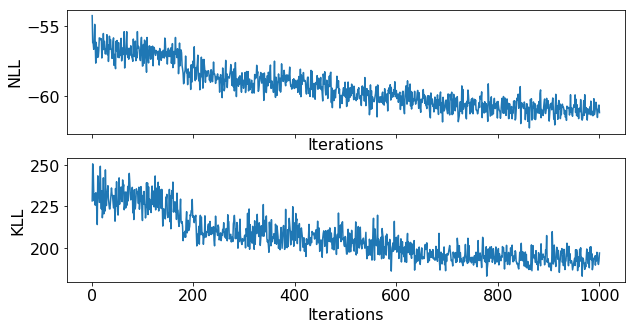

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))
loss_names, x, ys = trainer.losses()
for (ax, loss_name, y) in zip(axes, loss_names, ys):
    ax.plot(x, y)
    ax.set_ylabel(loss_name)
    ax.set_xlabel('Iterations')

In [43]:
# sample
n_samples = 20000
z = hamiltonian_prior.sample(n_samples)
xgen, dW = bg.flow(z, temperature=1.0)

In [44]:
import mdtraj

torsions_train = mdtraj.compute_dihedrals(training_data_traj, mct.Z_indices)

gen_data_traj = mdtraj.Trajectory(xgen[:, :66].detach().reshape(-1, 22, 3).numpy(), ala2_pdb)
torsions_gen = mdtraj.compute_dihedrals(gen_data_traj, mct.Z_indices)

In [45]:
def periodic_convolution(x, kernel):
    x_padded = np.concatenate([x, x, x])
    y_padded = np.convolve(x_padded, kernel, mode='same')
    return y_padded[x.size:-x.size]

In [46]:
torsion_hists_train = []
torsion_hists_gen = []
xticks = None

for i in range(torsions_train.shape[1]):
    htrain, e = np.histogram(torsions_train[:, i], 50, range=(-np.pi, np.pi), density=True);
    xticks = 0.5 * (e[1:] + e[:-1])
    hgen, _ = np.histogram(torsions_gen[:, i], 50, range=(-np.pi, np.pi), density=True);

    htrain = periodic_convolution(htrain, [0.25, 0.5, 1.0, 0.5, 0.25])
    hgen = periodic_convolution(hgen, [0.25, 0.5, 1.0, 0.5, 0.25])

    torsion_hists_train.append(htrain)
    torsion_hists_gen.append(hgen)

In [47]:
torsions_simple = [4, 5, 6, 7, 8]
torsions_complex = [0, 1, 2, 10, 12]

Text(-2.84159,0.9,'RNVP')

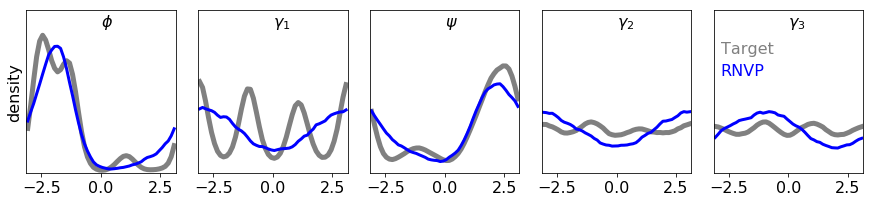

In [51]:
#fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15, 5))
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, sharex=True, figsize=(15, 3))
axes = axes.reshape((1, 5))
fig.subplots_adjust(hspace=0.05, wspace=0.15)
#for row, torsion_index in zip([0, 1], [torsions_simple, torsions_complex]):
for row, torsion_index in zip([0], [torsions_complex]):
    for i, ax in enumerate(axes[row]):
        ax.plot(xticks, torsion_hists_train[torsion_index[i]], color='grey', linewidth=5)
        ax.plot(xticks, torsion_hists_gen[torsion_index[i]], color='blue', linewidth=3)
        ax.set_yticks([])
        ax.set_xlim(-np.pi, np.pi)
        if row == 0:
            ax.set_ylim(0, 5)
        if row == 1:
            ax.set_ylim(0, 1.5)
        if row == 1:
            ax.set_xticks((-np.pi,0, np.pi))
            ax.set_xticklabels(('$-\pi$', 0,'$\pi$'))
    axes[-1,-1].set_yticks([])
axes[0, 0].set_ylim(0, 1.5)
axes[0, 0].text(0, 1.35, '$\phi$')
axes[0, 1].text(0, 1.35, '$\gamma_1$')
axes[0, 2].text(0, 1.35, '$\psi$')
axes[0, 3].text(0, 1.35, '$\gamma_2$')
axes[0, 4].text(0, 1.35, '$\gamma_3$')
axes[0, 0].set_ylabel('density')
#axes[1, 0].set_ylabel('density')
axes[0, -1].text(-np.pi+0.3, 1.1, 'Target', color='grey')
axes[0, -1].text(-np.pi+0.3, 0.9, 'RNVP', color='blue')

In [52]:
eps = 1e-5
for i in torsions_complex:
    KL_NF = np.sum(torsion_hists_train[i] * np.log((torsion_hists_train[i]+eps) / (torsion_hists_gen[i]+eps)))
    print("{:1.2f}".format(KL_NF))

1.71
3.95
0.81
0.72
0.87
